# Week 9: Sequence Models and Transformers

Additional references: 
- [Character Level Language Model (GPU required)](https://github.com/m2dsupsdlclass/lectures-labs/blob/master/labs/06_deep_nlp/Character_Level_Language_Model_rendered.ipynb)
- [Transformers (BERT fine-tuning): Joint Intent Classification and Slot Filling](https://github.com/m2dsupsdlclass/lectures-labs/blob/master/labs/06_deep_nlp/Transformers_Joint_Intent_Classification_Slot_Filling_rendered.ipynb)
- [Generating Language with huggingface](https://huggingface.co/blog/how-to-generate)
- [huggingface examples](https://huggingface.co/transformers/quickstart.html)

In [1]:
#setup
import warnings; warnings.simplefilter('ignore')
import pandas as pd
import numpy as np

df = pd.read_pickle('sc_cases_cleaned.pkl', compression='gzip')
df = df.assign(author_id=(df['authorship']).astype('category').cat.codes)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 768 entries, 0 to 819
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   case_name       768 non-null    object        
 1   opinion_type    768 non-null    object        
 2   date_standard   768 non-null    datetime64[ns]
 3   authorship      768 non-null    object        
 4   x_republican    768 non-null    float64       
 5   maj_judges      768 non-null    object        
 6   dissent_judges  768 non-null    object        
 7   topic_id        768 non-null    float64       
 8   cite_count      768 non-null    float64       
 9   opinion_text    768 non-null    object        
 10  year            768 non-null    int64         
 11  log_cite_count  768 non-null    float64       
 12  author_id       768 non-null    int8          
dtypes: datetime64[ns](1), float64(4), int64(1), int8(1), object(6)
memory usage: 78.8+ KB


# Huggingface Transformer

In [2]:
import torch
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification

# gpu or cpu?
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print (device)

cpu


Load the model from a pretrained checkpoint. 

In [3]:
model_name = 'distilbert-base-uncased' # huggingface model_ID or path to folder 
model = DistilBertForSequenceClassification.from_pretrained(model_name)
print (model)

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classi

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [4]:
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)
inputs = tokenizer(df.iloc[0]['opinion_text'], return_tensors="pt")
print(inputs)

#[32, 100, 23, 0, 0, 0, 0, 0] -> [1, 1, 1, 0, 0, 0, 0, 0]

Token indices sequence length is longer than the specified maximum sequence length for this model (4669 > 512). Running this sequence through the model will result in indexing errors


{'input_ids': tensor([[  101,  3425, 18353,  ...,  3641,  1012,   102]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]])}


In [5]:
inputs = tokenizer(df['opinion_text'].tolist(), return_tensors="pt", padding=True, truncation=True)
labels = torch.tensor(df['x_republican'].tolist()).long() 
print(inputs, labels)

{'input_ids': tensor([[  101,  3425, 18353,  ...,  6525,  3089,   102],
        [  101,  3425,  8799,  ...,  4781,  2580,   102],
        [  101,  3425,  1051,  ..., 13931,  9964,   102],
        ...,
        [  101,  3425,  8040,  ...,  2005,  1996,   102],
        [  101,  3425,  2726,  ...,  2015,  2006,   102],
        [  101,  3425,  1051,  ..., 25394, 11461,   102]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])} tensor([0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1,
        1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1

More infos about huggingface tokenizers can be found [here](https://huggingface.co/transformers/main_classes/tokenizer.html).

Now we have a set of text inputs and authors indicators as labels and we can train a transformers model using a cross-entropy loss function

In [6]:
unique_labels, counts = np.unique(df["x_republican"], return_counts=True)
print (unique_labels, counts)
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(unique_labels))

optimizer = torch.optim.Adam([
    {'params': model.distilbert.parameters(), 'lr': 1e-5},  
    {'params': model.classifier.parameters(), 'lr': 1e-3}
])


[0. 1.] [174 594]


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classi

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['opinion_text'].tolist(), df['x_republican'].tolist(), test_size=.2)

# generate batches
X_train, X_test, y_train, y_test = np.array(X_train[:608]), np.array(X_test[:152]), np.array(y_train[:608]), np.array(y_test[:152])
print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)

X_train, X_test, y_train, y_test = X_train.reshape(-1, 8), X_test.reshape(-1, 8), y_train.reshape(-1, 8), y_test.reshape(-1, 8)
print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)

X_train, X_test = X_train.tolist(), X_test.tolist()

(608,) (152,) (608,) (152,)
(76, 8) (19, 8) (76, 8) (19, 8)


In [8]:
# train
from tqdm import tqdm

num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    for text, labels in tqdm(zip(X_train, y_train), total=len(X_train)):
        # prepare model input through our tokenizer
        model_inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=256)
        # place everything on the right device
        model_inputs = {k:v.to(device) for k,v in model_inputs.items()}
        # labels have to be torch long tensors
        labels = torch.tensor(labels).long()
        # now, we can perform the forward pass
        output = model(**model_inputs, labels=labels)
        loss, logits = output[:2]
        # and the backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 76/76 [01:27<00:00,  1.15s/it]


In [9]:
predictions, targets = [], []
model.eval()


with torch.no_grad():
    for text, labels in tqdm(zip(X_test, y_test), total=len(X_test)):
        model_inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
        model_inputs = {k:v.to(device) for k,v in model_inputs.items()}

        output = model(**model_inputs)
        logits = output[0]
        # prediction is the argmax of the logits
        predictions.extend(logits.argmax(dim=1).tolist())
        targets.extend(labels)
        
from sklearn import metrics
accuracy = metrics.accuracy_score(targets, predictions)
print ("accuracy", accuracy)
classification_report = metrics.classification_report(targets, predictions)
print (classification_report)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:13<00:00,  1.38it/s]

accuracy 0.993421052631579
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98        30
         1.0       0.99      1.00      1.00       122

    accuracy                           0.99       152
   macro avg       1.00      0.98      0.99       152
weighted avg       0.99      0.99      0.99       152



So far, we considered the pytorch version for transformers. It also works with keras, a more in-depth tutorial can be found [here](https://towardsdatascience.com/working-with-hugging-face-transformers-and-tf-2-0-89bf35e3555a).

In [ ]:
!pip install tensorflow

In [10]:
from transformers import TFDistilBertForSequenceClassification, DistilBertConfig
import tensorflow as tf

# note that we use TFDistilBert... instead of DistilBert...

transformer_model = TFDistilBertForSequenceClassification.from_pretrained(model_name)

# define model input layer

input_ids = tf.keras.layers.Input(shape=(256,), name='input_token', dtype='int32')
input_masks_ids = tf.keras.layers.Input(shape=(256,), name='masked_token', dtype='int32')
X = transformer_model(input_ids, input_masks_ids)
model = tf.keras.Model(inputs=[input_ids, input_masks_ids], outputs = X)

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

2022-05-05 18:51:29.212525: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-05 18:51:29.212755: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-05-05 18:51:29.232833: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Metal device set to: Apple M1 Pro


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'vocab_projector', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'pre_classifier', 'dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use i

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 256)]        0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 256)]        0           []                               
                                                                                                  
 tf_distil_bert_for_sequence_cl  TFSequenceClassifie  66955010   ['input_token[0][0]',            
 assification (TFDistilBertForS  rOutput(loss=None,               'masked_token[0][0]']           
 equenceClassification)         logits=(None, 2),                                                 
                                 hidden_states=None                                           

In [12]:
model.compile(loss='sparse_categorical_crossentropy', # cost function
              optimizer='adam', # use adam as the optimizer
              metrics=['accuracy']) # compute accuracy, for scoring


In [13]:
# tokenize X_train
X_train, X_test, y_train, y_test = train_test_split(df['opinion_text'].tolist(), df['x_republican'].tolist(), test_size=.2)
X_train_tf = [tokenizer(x, return_tensors="tf", padding=True, truncation=True, max_length=256) for x in X_train]

In [14]:
input_ids, input_masks = [x["input_ids"][0].numpy() for x in X_train_tf], [x["attention_mask"][0].numpy() for x in X_train_tf]

dataset = tf.data.Dataset.from_tensor_slices(({'input_token': input_ids, 'masked_token': input_masks}, y_train)).batch(8)


In [15]:
model_info = model.fit(dataset,epochs=1)

2022-05-05 18:54:18.169262: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-05 18:54:18.169761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


77/77 [==============================] - 33s 335ms/step - loss: 0.7658 - accuracy: 0.7329


# LSTM in keras

Because we have an embedding lookup now, we can train an LSTM.


In [31]:
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
length_vocab = 10000
Y = df['x_republican']
X_one_hot = [one_hot(opinion, n=length_vocab) for opinion in df["opinion_text"]]
print (X_one_hot[0][:50])

[4440, 7346, 6759, 312, 4915, 5728, 312, 9977, 8828, 8087, 1233, 8828, 9674, 7025, 4764, 3607, 8577, 8865, 8429, 3081, 8491, 1435, 9544, 4275, 5993, 8222, 9393, 8828, 6679, 7745, 5100, 9575, 6728, 4731, 8176, 8649, 312, 8455, 3022, 6706, 312, 6873, 5728, 1736, 1194, 2658, 9544, 4275, 1054, 5409]


In [32]:
# next, we pad (or truncate) such that all the inputs have same length

max_seq_length = 2000
X_one_hot_padded = pad_sequences(X_one_hot, padding='post', maxlen=max_seq_length, truncating='post')
X_one_hot_padded.shape # (768, 2000)

(768, 2000)

In [36]:
from keras.layers import LSTM, Dense, Embedding
from keras.models import Sequential


model = Sequential() # create a sequential model
model.add(Embedding(length_vocab, 32, input_length=max_seq_length, name="embedding_layer"))
model.add(LSTM(32))
model.add(Dense(32, activation="relu"))
model.add(Dense(1, activation="sigmoid")) # output layer
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_layer (Embedding)  (None, 2000, 32)         320000    
                                                                 
 lstm_3 (LSTM)               (None, 32)                8320      
                                                                 
 dense_6 (Dense)             (None, 32)                1056      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 329,409
Trainable params: 329,409
Non-trainable params: 0
_________________________________________________________________


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


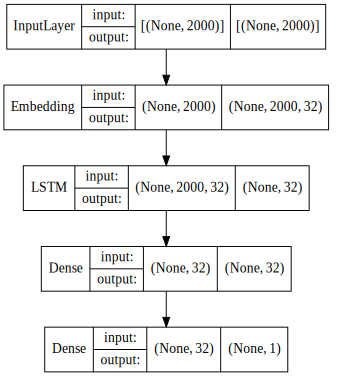

In [23]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
dot = model_to_dot(model,
                   show_shapes=True,
                   show_layer_names=False,
                   dpi=70)
SVG(dot.create(prog='dot', format='svg'))

In [35]:
model.compile(loss='binary_crossentropy', # cost function
              optimizer='adam', # use adam as the optimizer
              metrics=['accuracy']) # compute accuracy, for scoring

model_info = model.fit(X_one_hot_padded, Y, 
                      epochs=3,
                      validation_split=.2, batch_size=32)

Epoch 1/3


2022-05-05 19:54:36.658818: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-05 19:54:36.888325: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-05 19:54:47.805706: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/20 [===========================>..] - ETA: 0s - loss: 0.6579 - accuracy: 0.7747

KeyboardInterrupt: 

**Text Vectorization Layer** <br>
more details [here](https://keras.io/api/layers/preprocessing_layers/core_preprocessing_layers/text_vectorization/).

In [39]:
from keras.layers import TextVectorization
import tensorflow as tf
from keras.layers import LSTM


text_dataset = tf.data.Dataset.from_tensor_slices(df["opinion_text"])
max_features = 10000  # Maximum vocab size.
max_len = 2000  # Sequence length to pad the outputs to.

# Create the layer.  
vectorize_layer = TextVectorization(
 max_tokens=max_features,
 output_mode='int',
 output_sequence_length=max_len)
# Now that the vocab layer has been created, call `adapt` on the text-only  
# dataset to create the vocabulary. You don't have to batch, but for large  
# datasets this means we're not keeping spare copies of the dataset.


vectorize_layer.adapt(text_dataset.batch(64))


2022-05-05 20:00:50.304290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [40]:
model = tf.keras.models.Sequential()



model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)
model.add(Embedding(max_features, 64, name="embedding_layer"))
model.add(LSTM(64))
model.add(Dense(64, activation="relu"))
model.add(Dense(1, activation="sigmoid")) # output layer
model.summary()

model.compile(loss='binary_crossentropy', # cost function
              optimizer='adam', # use adam as the optimizer
              metrics=['accuracy']) # compute accuracy, for scoring

model_info = model.fit(df["opinion_text"], Y, 
                      epochs=3,
                      validation_split=.2, batch_size=32)


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 2000)             0         
 torization)                                                     
                                                                 
 embedding_layer (Embedding)  (None, 2000, 64)         640000    
                                                                 
 lstm_4 (LSTM)               (None, 64)                33024     
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 677,249
Trainable params: 677,249
Non-trainable params: 0
________________________________________________

2022-05-05 20:00:54.130902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-05 20:00:54.412815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-05 20:01:05.444359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - ETA: 0s - loss: 0.6277 - accuracy: 0.7508

2022-05-05 20:02:56.335235: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-05 20:02:56.425617: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 145s 5s/step - loss: 0.6277 - accuracy: 0.7508 - val_loss: 0.5600 - val_accuracy: 0.7662
Epoch 2/3
20/20 [==============================] - 14s 701ms/step - loss: 0.5263 - accuracy: 0.7752 - val_loss: 0.5468 - val_accuracy: 0.7662
Epoch 3/3
20/20 [==============================] - 14s 706ms/step - loss: 0.4732 - accuracy: 0.7752 - val_loss: 0.5661 - val_accuracy: 0.7662


**Deep learning tips, tricks and advanced features**

In [ ]:
# Set up a basic model again for advanced features.
from keras.models import Sequential
from keras.layers import Activation, Dense
model = Sequential()
# set custom activation, specify input dim
model.add(Dense(64, input_dim=1000, activation='gelu')) 


In [ ]:
# initializers
model.add(Dense(64, kernel_initializer='he_normal'))
model.add(Dense(64, kernel_initializer='he_uniform'))


In [ ]:
# other activation functions (https://keras.io/activations/)
model.add(Dense(64, activation="elu"))

In [ ]:
# batch normalization
from keras.layers.normalization import BatchNormalization
model.add(Dense(64, use_bias=False)) 
model.add(BatchNormalization())
model.add(Activation('relu'))

In [ ]:
# regularization
from keras.regularizers import l1, l2, l1_l2
model.add(Dense(64, 
                kernel_regularizer=l2(0.01),
                activity_regularizer=l1(0.01)))
model.add(Dense(64, 
                kernel_regularizer=l1_l2(l1=0.01,l2=.01),
                activity_regularizer=l1_l2(l1=0.01,l2=.01)))

In [ ]:
# Dropout
from keras.layers import Dropout
# np.random.rand(1000)
model.add(Dropout(0.5))

In [ ]:
model.add(Dense(1,activation='sigmoid'))

In [ ]:
model.summary()

In [ ]:
# Optimizers
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# different loss functions

model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
# Early stopping
from keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor='val_accuracy', 
                          min_delta=0.0001, 
                          patience=5, 
                          mode='auto')


model.fit(X.todense(), Y, batch_size=128, 
           epochs=100, 
           callbacks=[earlystop], 
           validation_split=0.2)

In [ ]:
# Batch Training with Large Data
from numpy import memmap
X_mm = memmap('X.pkl',shape=(768, 1000))

model.fit(X_mm, Y, batch_size=128, 
           epochs=3, 
           validation_split=0.2)

In [ ]:
# Grid search with KerasClassifier


from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

# instantiate KerasClassifier with build function
def create_model(hidden_layers=1):  
    model = Sequential()
    model.add(Dense(16, input_dim=1000, 
                    activation='relu')) 
    for i in range(hidden_layers):
        model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', 
                optimizer='adam', 
                metrics= ['accuracy'])
    return model

clf = KerasClassifier(create_model)

# set of grid search CV to select number of hidden layers
params = {'hidden_layers' : [0,1,2,3]}
grid = GridSearchCV(clf, param_grid=params)
grid.fit(X.todense(),Y)
grid.best_params_